# Addressing substance problems online

This study tries to answer the following questions:

1) Is it more common in males of females? Which age?

2) Which profession has the largest percentage of users with a probable substance problem?

3) Does having kids decrease the likelihood of substance abuse?

4) Does taking religion seriously help prevent substance abuse?

5) Do healthy choices like not smoking and vegetarian diets correlate negatively with substance abuse?



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("../data/profiles.csv")

## Selecting the useful variables

- diet
- drinks
- drugs
- education
- job
- offspring
- pets
- religion
- sex
- smokes
- status

Let's ditch all the rest:

- body_type
- ethnicity
- height
- income
- last_online
- location
- orientation
- sign
- speaks
- essay from 0 to 9

In [3]:
df.drop(["body_type", "ethnicity", "height", "income", "last_online", "location", "orientation",
        "sign", "speaks", "essay0", "essay1", "essay2", "essay3", "essay4", "essay5", "essay6",
        "essay7", "essay8", "essay9"], axis=1, inplace=True)

## Defining and creating the target variable

Firstly, we need to clearly define what substance abuse is. According to [Wikipedia](https://en.wikipedia.org/wiki/Substance_abuse):

> Substance abuse, also known as drug abuse, is use of a drug in amounts or by methods which are harmful to the individual or others. (...) Drugs most often associated with this term include: alcohol, amphetamines, barbiturates, benzodiazepines, cannabis, cocaine, hallucinogens, methaqualone, and opioids.

The OkCupid dataset isn't precise in terms of which drugs its users consume, but it gives us a few clues about their quantity. Let's recap:

- The `drinks` variable possible values are: very often, often, socially, rarely, desperately, not at all
- The `drugs` possible values are: never, sometimes, often

I'm going to assume that users who either drink "very often" or "desperately", or use drugs "often" are likely candidates for the group of users with a substance problem. I'm going to name it as `abuse`, and convert the possible values of `drinks` and `drugs` the variables `alcohol_problem`, `drugs_problem`, and `both_problems`, which will either be 0 or 1. 

In [4]:
df["alcohol_problem"] = df['drinks'].apply(lambda x: 1 if (x=="very often") or (x=="desperately") else 0)
df.drop("drinks", axis=1, inplace=True)

df["drugs_problem"] = df['drugs'].apply(lambda x: 1 if (x=="often") else 0)
df.drop("drugs", axis=1, inplace=True)

df['both_problems'] = df["drugs_problem"] & df["alcohol_problem"]
df['alcohol_problem_only'] = df['alcohol_problem'] & ~df['drugs_problem']
df['drugs_problem_only'] = ~df['alcohol_problem'] & df['drugs_problem']

df['abuse'] = df['alcohol_problem'] | df['drugs_problem']

## Answering the questions

In [5]:
sns.set_style("white")
sns.set_palette("rocket_r")
sns.set_context("notebook")

### Question #1 - Is it more common in males of females? Which age?

In [6]:
df["age_group"] = pd.cut(df['age'], bins=[18,24,30,40,50,60,80])

In [7]:
df["sex"] = df["sex"].replace({"m": 0, "f": 1})

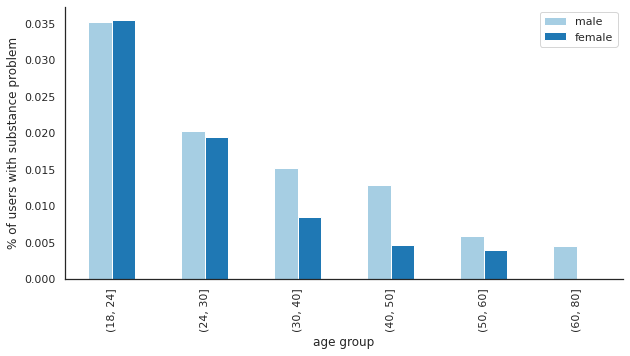

In [8]:
sns.set_palette("Paired")

male = df[df["sex"] == 0].groupby("age_group")["abuse"].mean().to_frame()
female = df[df["sex"] == 1].groupby("age_group")["abuse"].mean().to_frame()
has_kids = pd.concat([male, female], axis=1)
has_kids.columns = ["male", "female"]

has_kids.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

### Question #1 - Which profession has the largest percentage of users with a probable substance problem?

In [9]:
df["job"].fillna("rather not say", inplace=True)

I'm not sure why OkCupid let people choose an item like `rather not say` since not picking any value would have the same result (thus producing NaNs). Anyway, I decided to convert all NaNs into "rather not say".

In [10]:
job_relative = df.groupby("job")['abuse'].mean().sort_values().to_frame()
job_relative*100

,abuse
job,
banking / financial / real estate,0.794351
executive / management,1.011378
medicine / health,1.059783
transportation,1.092896
education / academia,1.110162
science / tech / engineering,1.237624
clerical / administrative,1.366460
computer / hardware / software,1.507751
sales / marketing / biz dev,1.548622


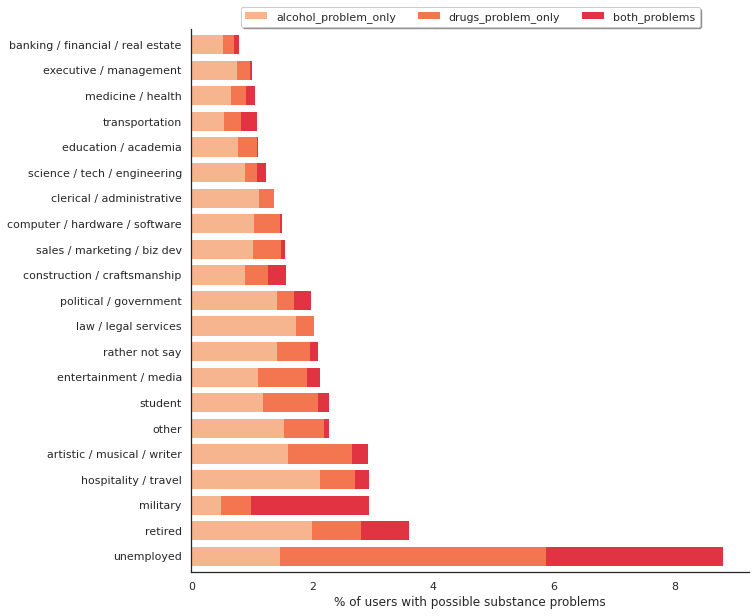

In [11]:
sns.set_style("white")
sns.set_palette("rocket_r")
sns.set_context("notebook")

jobs_stacked = df.groupby("job").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
jobs_stacked.drop('abuse', axis=1, inplace=True)
jobs_stacked.plot(kind='barh', stacked=True, figsize=(10,10), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

### Question 2) Does having kids decrease the likelihood of substance abuse?


According to the `okcupid_codebook.txt` file, the possible values of `status` are single, seeing someone, married, and in an open relationship. I'll replace the value "available" with the latter since it's more explainative.

In [12]:
df["status"] = df["status"].replace({"available": "in an open relationship"})

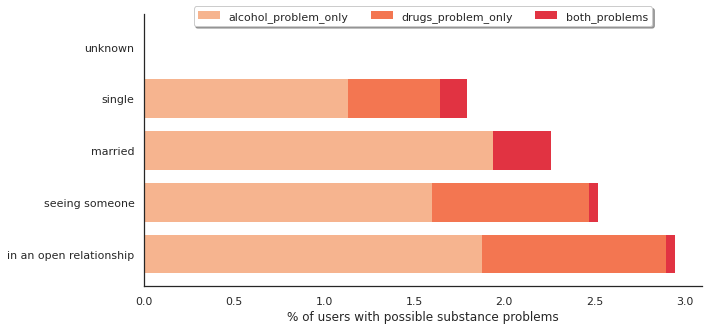

In [13]:
sns.set_style("white")
sns.set_palette("rocket_r")
sns.set_context("notebook")

status_stacked = df.groupby("status").mean()[['alcohol_problem_only',
                                               'drugs_problem_only',
                                               'both_problems',
                                               'abuse']].sort_values('abuse')*100
status_stacked.drop('abuse', axis=1, inplace=True)
status_stacked.plot(kind='barh', stacked=True, figsize=(10,5), width=0.75, linewidth=0)
plt.ylabel("")
plt.xlabel("% of users with possible substance problems")
plt.gca().invert_yaxis()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
sns.despine()
plt.show()

This variable is tricky. Almost 60% of the respondents chose not to say whether they had kids, so dropping the NaNs may greatly affect the outcomes.

In [14]:
df['offspring'].isnull().mean()

0.5932172288392887

Whoever said that "doesn't have kids" (and might or might not want them), or simply "wants kids" will have the offspring variable set to zero, while everything else will be replaced with ones.

In [15]:
df.dropna(axis=0, subset=["offspring"], inplace=True)
df['offspring'].replace(['doesn&rsquo;t have kids',
                         'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
                         'doesn&rsquo;t have kids, but might want them',
                         'doesn&rsquo;t have kids, but wants them',
                         'might want kids',
                         'doesn&rsquo;t want kids',
                         'wants kids'], 0, inplace=True)

df['offspring'].replace(['has a kid',
                         'has a kid, and might want more',
                         'has a kid, and wants more',
                         'has a kid, but doesn&rsquo;t want more',
                         'has kids',
                         'has kids, and might want more',
                         'has kids, and wants more',
                         'has kids, but doesn&rsquo;t want more',], 1, inplace=True)

There's also the problem of colinearity with age. Young adults are much less likely to have kids, and that will impact the outcome of the correlation study with substance abuse. It would be more reasonable to observe differences by age groups.

In [16]:
table_offspring = pd.concat([df["age_group"].value_counts(), (1-df.groupby("age_group")["offspring"].mean())*100], axis=1)
table_offspring.columns = ["no. of users", "percentage without kids"]
table_offspring.index.rename("age group", inplace=True)
table_offspring

,no. of users,percentage without kids
age group,,
"(18, 24]",3943,96.221151
"(24, 30]",7291,95.103552
"(30, 40]",7109,83.415389
"(40, 50]",3527,55.231075
"(50, 60]",1664,31.069712
"(60, 80]",677,25.406204


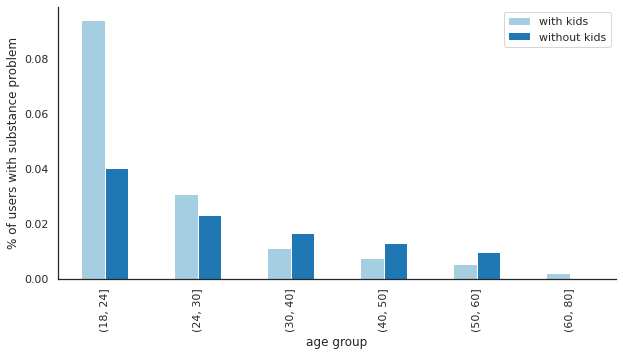

In [17]:
sns.set_palette("Paired")

has_kids_yes = df[df["offspring"] == True].groupby("age_group")["abuse"].mean().to_frame()
has_kids_no = df[df["offspring"] == False].groupby("age_group")["abuse"].mean().to_frame()
has_kids = pd.concat([has_kids_yes, has_kids_no], axis=1)
has_kids.columns = ["with kids", "without kids"]

has_kids.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

Now I'm curious. Kids may not help prevent substance abuse with age, but what about pets?

In [18]:
df.dropna(axis=0, subset=["pets"], inplace=True)
df['has_dogs'] = df['pets'].apply(lambda x: 1 if ("has dogs" in x) else 0)
df['has_cats'] = df['pets'].apply(lambda x: 1 if ("has cats" in x) else 0)
df['has_pets'] = df[['has_dogs', 'has_cats']].any(axis=1)

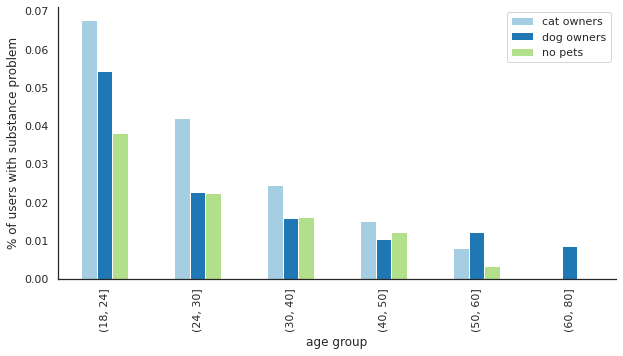

In [20]:
sns.set_palette("Paired")
has_cats = df[df["has_cats"] == True].groupby("age_group")["abuse"].mean().to_frame()
has_dogs = df[df["has_dogs"] == True].groupby("age_group")["abuse"].mean().to_frame()
has_none = df[df["has_pets"] == False].groupby("age_group")["abuse"].mean().to_frame()
has_pets = pd.concat([has_cats, has_dogs, has_none], axis=1)
has_pets.columns = ["cat owners", "dog owners", "no pets"]

has_pets.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

## 3) Does taking religion seriously help prevent substance abuse?

The `religion` variable has several possible values plus a few modifiers ("laughing about it, "somewhat serious about it", etc). I thought of creating a new variable out of these modifiers called `religious`, which is going to be 1 if `religion` is not atheism or agnosticism (for obvious reasons), and the `religion` modifier has the "very serious about it" modifier. 

In [ ]:
df.dropna(axis=0, subset=["religion"], inplace=True)
df['religious'] = df['religion'].apply(lambda x: 1 if "very serious" in x else 0)
df['religious'] = ~df['religion'].isin(["agnosticism", "atheism"]) & df['religious'] == 1

df['religion'].replace([" and laughing about it",
                       " and somewhat serious about it",
                       " and very serious about it",
                       " but not too serious about it"], "", regex=True, inplace=True)

In [ ]:
sns.set_palette("Paired")

religious_yes = df[df["religious"] == True].groupby("age_group")["abuse"].mean().to_frame()
religious_no = df[df["religious"] == False].groupby("age_group")["abuse"].mean().to_frame()
religious = pd.concat([religious_yes, religious_no], axis=1)
religious.columns = ["takes religion seriously", "atheist or cool about it"]

religious.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

### Question #5 - Do healthy choices like not smoking and vegetarian diets correlate negatively with substance abuse?

In [ ]:
df["smokes"] = df["smokes"].replace({"yes": 1,
                                    "sometimes": 1,
                                    "when drinking": 1,
                                    "trying to quit": 1,
                                    "no": 0})

The "diet" variable has 6 possible values (anything, vegetarian, vegan, kosher, halal, and other) and 2 modifiers (mostly/strictly), which might create unnecessary dummy variables that won't add value to the model. So let's boil it down to diet type without the nuance.

In [ ]:
df.dropna(axis=0, subset=['diet'], inplace=True)
df['vegetarian'] = df['diet'].apply(lambda x: 1 if ("vegetarian" in x) or ("vegan" in x) else 0)

In [ ]:
sns.set_palette("crest")

vegetarian_yes = df[df["vegetarian"] == True].groupby("age_group")["abuse"].mean().to_frame()
vegetarian_no = df[df["vegetarian"] == False].groupby("age_group")["abuse"].mean().to_frame()
vegetarian = pd.concat([vegetarian_yes, vegetarian_no], axis=1)
vegetarian.columns = ["vegetarian", "not vegetarian"]

vegetarian.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

In [ ]:
sns.set_palette("rocket_r", n_colors=2)

smokes_yes = df[df["smokes"] == True].groupby("age_group")["abuse"].mean().to_frame()
smokes_no = df[df["smokes"] == False].groupby("age_group")["abuse"].mean().to_frame()
smokes = pd.concat([smokes_yes, smokes_no], axis=1)
smokes.columns = ["smoker", "non-smoker"]

smokes.plot.bar(figsize=(10,5))
plt.ylabel("% of users with substance problem")
plt.xlabel("age group")
sns.despine()
plt.show()

In [5]:
df_useful = df[]

## Exploratory analysis

In [11]:
def create_dummy(df):
    """
    Creates dummy variables for all the categorial variables in a DataFrame and concatenates it
    with the original numerical columns.
    Input: pandas DataFrame
    Output: pandas DataFrame
    """
    cat_cols = df.select_dtypes(include="object").columns
    num_cols = df.select_dtypes(exclude="object").columns
    dummy_df = pd.get_dummies(df[cat_cols],
                              prefix=cat_cols,
                              prefix_sep="_",
                              dummy_na=True,
                              columns=cat_cols)
                              
    df_new = pd.concat([df[num_cols], dummy_df], axis=1)
    return df_new

In [12]:
df_dummy = pd.concat([create_dummy(df), df[['job', 'religion', 'status', 'education']], ], axis=1)

In [13]:
sns.set_theme(style="whitegrid")

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline

In [76]:
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

y = df_dummy["abuse"]
X = df_dummy.drop("abuse", axis=1)
X.drop(['job',
        'religion',
        'status', 
        "has_pets",
        "alcohol_problem", 
        "drugs_problem",
        "both_problems",
        "alcohol_problem_only",
        "drugs_problem_only",
        "education"], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# concatenate our training data back together
X = pd.concat([pd.DataFrame(X_train), y_train], axis=1)

# separate minority and majority classes
not_abuse = X[X.abuse==0]
abuse = X[X.abuse==1]

# upsample minority
abuse_upsampled = resample(abuse,
                          replace=True, # sample with replacement
                          n_samples=len(not_abuse), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_abuse, abuse_upsampled])

y_train = upsampled.abuse
X_train = upsampled.drop('abuse', axis=1)

In [77]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [81]:
coef_table = pd.DataFrame(model.named_steps["logisticregression"].coef_[0], index=X_train.columns, columns=["coef"])

In [135]:
coef_table.sort_values("coef").tail(40)

,coef
job_unemployed,0.040878
status_available,0.042761
job_artistic / musical / writer,0.047561
religion_hinduism,0.049310
body_type_rather not say,0.050172
job_construction / craftsmanship,0.052299
education_college/university,0.052865
education_graduated from high school,0.054320
education_working on law school,0.063536
sex_m,0.064808


In [142]:
features = ["smokes_yes", "religious", "age", "job_unemployed",
           ]

In [143]:
model.fit(X_train[features], y_train)
precision_score(y_test, model.predict(X_test[features]))

0.050505050505050504

In [144]:
roc_auc_score(y_test, model.predict(X_test[features]))

0.6456858950287415